### Testing basic convolution, fft, scoring metric for subsequence existence

In [18]:
from scipy.fft import fft, ifft
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

In [19]:
from ont_fast5_api.fast5_interface import get_fast5_file

### Data extraction from f5

In [20]:
def get_data_from_fast5(fast5_filepath):
    data_arr = []
    read_ids = []
    with get_fast5_file(fast5_filepath, mode="r") as f5:
        for read in f5.get_reads():
            raw_data = read.get_raw_data()
            read_ids.append(read.read_id)
            data_arr.append(raw_data)
    return read_ids, data_arr

In [4]:
f5_filepath = r"data\FAW71953_6c8b1e8d_944d09f0_2.fast5"
_, data_arr = get_data_from_fast5(f5_filepath)

### Nanopore signal cleaning

In [21]:
from scipy.signal import butter, filtfilt, savgol_filter

def clean_signal(signal, fs=4000, cutoff=2):
    b, a = butter(2, cutoff/(0.5*fs), btype='high') # high pass filter
    signal = filtfilt(b, a, signal) # digital filter
    signal = savgol_filter(signal, window_length=11, polyorder=3) # smoothing
    return(signal - np.mean(signal)) / np.std(signal) # norming


### FFT cross-correlation

In [22]:
import numpy as np

def cross_correlation_fft(x, y):
    # Ensure equal length
    n = len(x) + len(y) - 1
    n_padded = 1 << (n - 1).bit_length()  # next power of 2 for efficiency
    
    # FFT of both signals
    X = np.fft.fft(x, n_padded)
    Y = np.fft.fft(y, n_padded)
    
    # Multiply X with conjugate of Y
    corr = np.fft.ifft(X * np.conj(Y))
    
    # Only the real part is meaningful
    return np.real(corr)


### Helixworks based analysis

In [7]:
import pandas as pd

In [8]:
def reverse_complement(dna):
    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
    return ''.join(complement[base] for base in reversed(dna))

In [9]:
# getting rc version of the spacers
spacers = [
'TTGGATAAGAGGCGTTGGGAGTAAA',
'GATTAAGAGGCGTGGATGAAAGTAT',
'GAAGAGTGCGTGTGAGATAGATAGG',
'TGCGGGTAGGTGAAAGTAGGATGTG',
'GTGGAGAAGTGAGTAGGAAAGTAAG',
'GTGGTAGTAAGTAGAAGTGTGTGAG',
'GCGAATGAAGGGTAGTATATAGGAG',
'TTTGTGCGATGGTGGGATGGAAGAA',
'GCGGGGATAAAGGTAGAAAAGGTAA',
'AGGGATGGAGCTGGGTTGTATGTAA',
'ATAGTGTAGTTGGGATGGGCAGAGA'
]

rev_spacers = [reverse_complement(i) for i in spacers]

In [10]:
len(spacers[0])

25

In [11]:
rev_spacers

['TTTACTCCCAACGCCTCTTATCCAA',
 'ATACTTTCATCCACGCCTCTTAATC',
 'CCTATCTATCTCACACGCACTCTTC',
 'CACATCCTACTTTCACCTACCCGCA',
 'CTTACTTTCCTACTCACTTCTCCAC',
 'CTCACACACTTCTACTTACTACCAC',
 'CTCCTATATACTACCCTTCATTCGC',
 'TTCTTCCATCCCACCATCGCACAAA',
 'TTACCTTTTCTACCTTTATCCCCGC',
 'TTACATACAACCCAGCTCCATCCCT',
 'TCTCTGCCCATCCCAACTACACTAT']

In [129]:
library_df = pd.read_csv(r"C:\Users\Parv\Doc\RA\Projects\DSP\data\motif_design_sequences.csv")

In [133]:
library_df

,motif name,seqeunce,sequence orientation,strand
0,5pf,ACTTACCCGCTACTTTCATCACTAA,5' to 3',plus
1,_1,AACAACATCAATCCTACATCGCCTA,5' to 3',plus
2,_2,ATATACCTCGCCTCATCTCAATCAA,5' to 3',plus
3,_3,TTTCACTTCTTATCCGCCTCACCTA,5' to 3',plus
4,_4,CACCTTCACCTTACCTACTCAATTC,5' to 3',plus
5,_5,CAACCCTCTATCCGCCTCTCCACTA,5' to 3',plus
6,_6,AACCCATCACTTACCTCTCTTAACA,5' to 3',plus
7,_7,CCATCCATATCATTTTCTCCTTACC,5' to 3',plus
8,_8,CCACATCTACCCTTCCACTCTATCA,5' to 3',plus
9,3pf,ACCACCTCGCATCATACCTACCTTA,5' to 3',plus


In [12]:
seqs = library_df['seqeunce'].tolist()

NameError: name 'library_df' is not defined

In [ ]:
rc_seqs = [reverse_complement(i) for i in seqs]

In [ ]:
tseqs = seqs + rc_seqs

In [13]:
def write_fasta(strands, filepath=r"C:\Users\Parv\Doc\HelixWorks\Basecalling\squigulator\sample.fa.txt"):
    counter = 3793
    with open(filepath, 'w') as f:
        for strand in strands:
            f.write(f'>>seq_{counter} {len(strand)}bp\n')
            f.write(strand)
            f.write('\n\n')
            counter += 1

In [142]:
write_fasta(tseqs)

### Spacer positions within full motif choices

In [14]:
for ptr, seq in enumerate(seqs[:-1]):
    if ptr == 0:
        cycle_position = 0
    else:
        cycle_position = int((ptr - 1) / 8)

    print(seq)
    print(rev_spacers[cycle_position][12:] + "A"*25 + rev_spacers[cycle_position+1][:12])
    print()
    #print(rev_spacers[cycle_position][12:] + "A"*25 + rev_spacers[cycle_position+1][13:])
    """
    for i, j in zip(rev_spacers, spacers):
        if i[12:] in seq:
            print(seq)
            print(i[12:] + "A"*25 + i[:12])
            print(i[:12])
            print(j)
        #if j[12:] in seq:
        #    print(j)
    """

NameError: name 'seqs' is not defined

### Testing spacer finding using DSP

In [15]:
_, motif_data = get_data_from_fast5(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\squigulator\slow5tools-v1.1.0\testing.fast5")

In [16]:
len(motif_data)

42

In [21]:
def create_motif_payload_sequence(data_squiggle):
    motif_signal_positions = []
    max_match_scores = []
    corrs = []

    n_padded = len(data_squiggle) + 405

    get_fft = lambda x: np.fft.fft(clean_signal(x), n_padded)

    data_fft = get_fft(data_squiggle)
    fft_motifs = [get_fft(motif) for motif in motif_data]

    for motif_index, motif in enumerate(fft_motifs):
        corr = np.real(np.fft.ifft(
            data_fft * np.conj(motif)))

        best_position = np.argmax(corr)
        best_match_score = np.max(corr)
        
        motif_signal_positions.append(best_position)
        max_match_scores.append(best_match_score)
        corrs.append(corr)

    return motif_signal_positions, max_match_scores, corrs

In [71]:
def display_correlation_clean(corr, threshold=100):
    plt.plot([i if i > 100 else 0 for i in corr])

def get_positions_of_correlation_spikes(corr, threshold=100):
    return [i for i, j in enumerate(corr) if j > threshold]

In [22]:
motif_signal_positions, max_match_scores, corrs = create_motif_payload_sequence(data_arr[0])

In [23]:
corrs[0]

array([7.04439465, 4.52128703, 1.11174713, ..., 7.26293405, 8.56962982,
       8.53078163])

In [72]:
motif_corrs = corrs[11:22]
position_motif_wide = [get_positions_of_correlation_spikes(i) for i in motif_corrs]

In [93]:
# Select a single spacer
spacer_selected = clean_signal(motif_data[20]) # 1_splint


spike_positions = []
for i in data_arr[:200]:

    if len(i) > 10000:
        continue

    corr_arr = cross_correlation_fft(clean_signal(i), spacer_selected)
    spike_positions.append(get_positions_of_correlation_spikes(corr_arr, threshold=120))

    


In [81]:
corr = cross_correlation_fft(clean_signal(data_arr[20]), spacer_selected)

In [82]:
len(corr)

4096

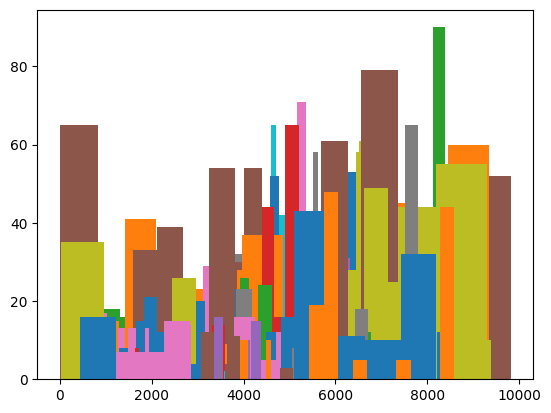

In [94]:
for i in spike_positions:
    plt.hist(i)

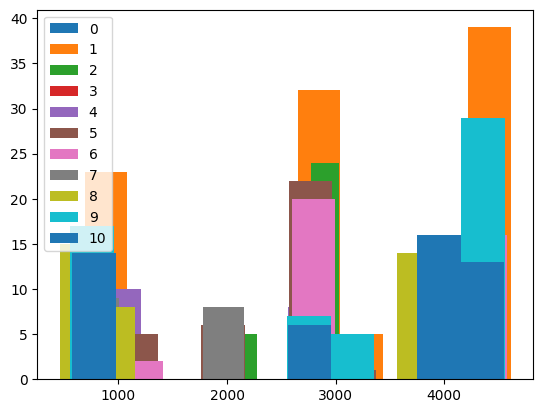

In [73]:
for i, j in enumerate(position_motif_wide):
    plt.hist(j, label=f"{i}")


plt.legend()
plt.show()

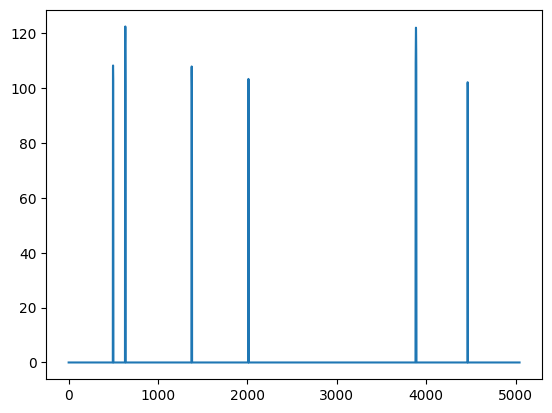

In [31]:
display_correlation_clean(corrs[7])

In [124]:
extracted_motif_positions = [i for i, j in zip(motif_signal_positions, max_match_scores) if j > 200]
chosen_motifs = [i+1 for i, j in enumerate(max_match_scores) if j > 250]

In [127]:
np.mean(max_match_scores)

np.float64(220.9709502401191)

In [128]:
np.std(max_match_scores)

np.float64(37.39114983763821)

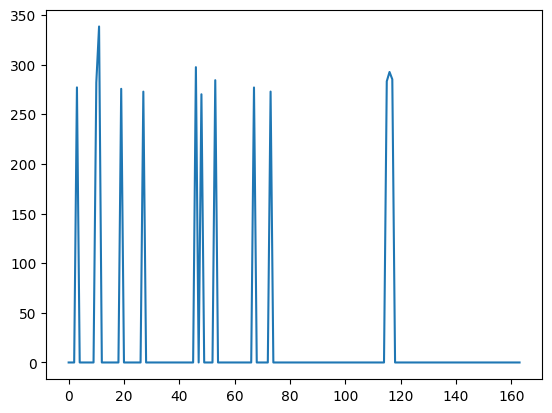

In [108]:
plt.plot([i if i > 270 else 0 for i in max_match_scores])

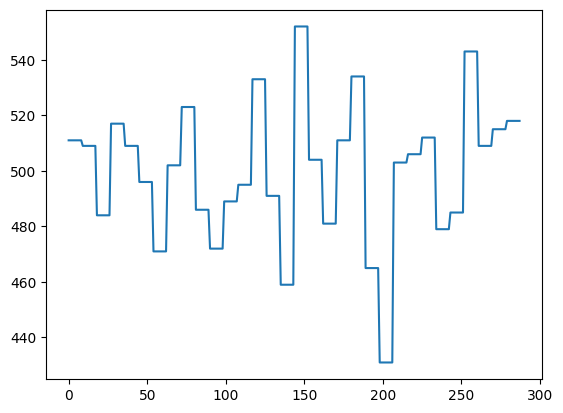

In [83]:
plt.plot(data[0])

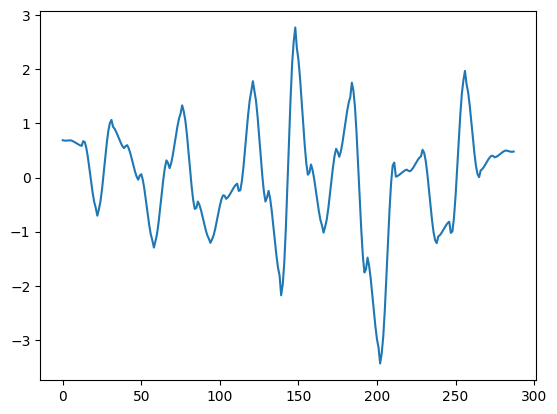

In [84]:
plt.plot(clean_signal(data[0]))

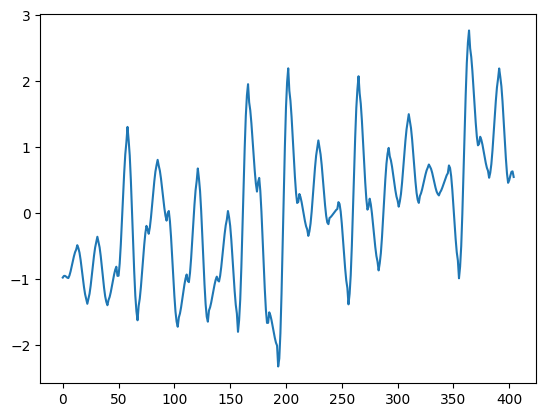

In [16]:
plt.plot(spacer_rep)

Remember strands can be reverse complemented and forward

In [26]:
from tqdm.notebook import tqdm

In [36]:
corrs = []
motif_position = []
motif_current = []
for i in tqdm(data_arr):
    corr = cross_correlation_fft(clean_signal(i), clean_signal(data[1]))
    corrs.append(corr)
    motif_position.append(np.argmax(corr)/8)
    max_current = motif_current.append(np.max(corr))

  0%|          | 0/4000 [00:00<?, ?it/s]

(array([2543., 1041.,  228.,   75.,   29.,   38.,   23.,    8.,    9.,
           6.]),
 array([ 141.34312827,  249.81534647,  358.28756468,  466.75978289,
         575.2320011 ,  683.7042193 ,  792.17643751,  900.64865572,
        1009.12087393, 1117.59309213, 1226.06531034]),
 <BarContainer object of 10 artists>)

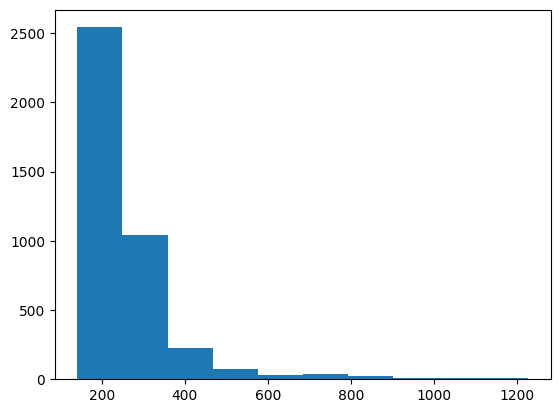

In [32]:
plt.hist(motif_current)

In [37]:
posis = [i for i, j in zip(motif_position, motif_current) if j > 300]

In [49]:
37 * 8 + 50 * 16

1096

In [50]:
50 * 8

400

In [45]:
np.mean(posis)

np.float64(2247.255221518987)

In [21]:
corr = cross_correlation_fft(clean_signal(data_arr[0]), clean_signal(data[1]))

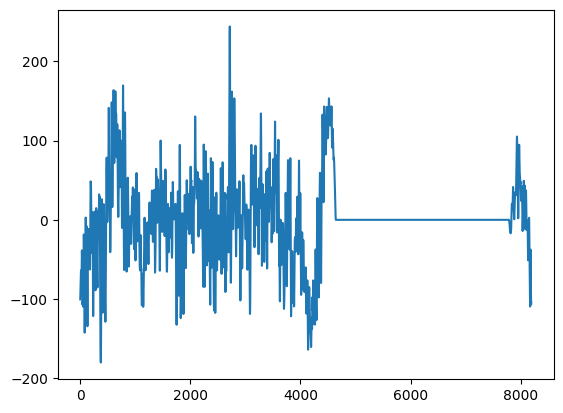

In [22]:
plt.plot(corr)

In [46]:
np.argmax(corr) / 8

np.float64(93.125)

In [40]:
np.argmax(corr) / 8

np.float64(61.875)

37 + 50 + ...

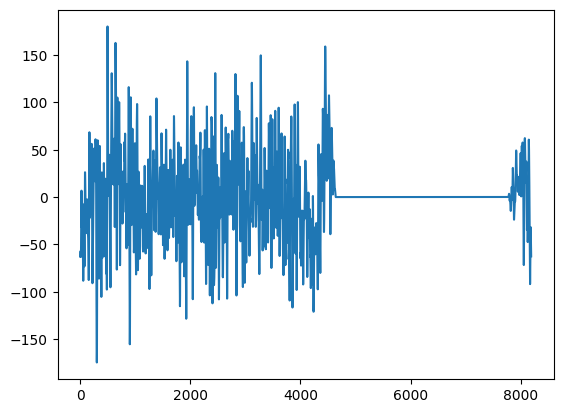

In [41]:
plt.plot(corr)

In [51]:
t = [i if i > 150 else 0 for i in corr]

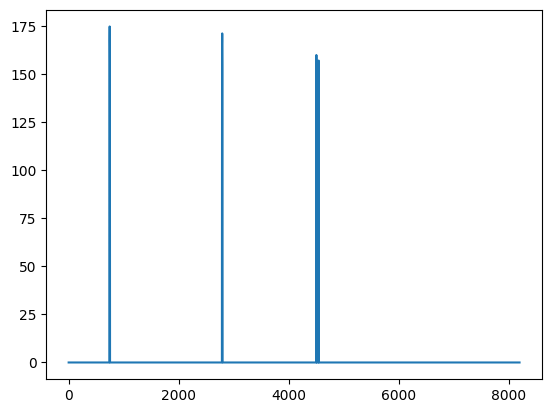

In [52]:
plt.plot(t)

In [216]:
best_shift = np.argmax(corr)
best_similarity = corr[best_shift]


In [ ]:
best_shiftb

np.int64(3999)

### Sequencing data

From the run - pod5vsFastq_170524_75ntV2_OK
AGTGTCTGTGACCAGTACGACCCAGTACCGTCACGGTTAGGAAGCTCCTCGCTTCTTAGCCGTCACGCCAAAGTG

In [4]:
import pod5 as p5

# Reading pod5 data
def read_pod5_file(filepath):
    read_ids = []
    squiggles = []
    with p5.Reader(filepath) as reader:
        for read_record in reader.reads():
            read_ids.append(read_record.read_id)
            squiggles.append(read_record.signal)
            

    return squiggles, read_ids

In [5]:
squiggles, read_ids = read_pod5_file(r"C:\Users\Parv\Doc\RA\Projects\DSP\data\pod5vsFastq_170524_75ntV2_OK\pod5_pass\ATQ988_pass_22e98598_8902973c_3.pod5")

In [ ]:
original_strand = "AGTGTCTGTGACCAGTACGACCCAGTACCGTCACGGTTAGGAAGCTCCTCGCTTCTTAGCCGTCACGCCAAAGTG"

75

In [47]:
# Making a list of all possible 40mers and generating singal using squigulator for testing
subseqs = [original_strand[i: i + 40] for i in range(0, len(original_strand) - 40)]
write_fasta(subseqs)

In [48]:
_, motif_data = get_data_from_fast5(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\squigulator\slow5tools-v1.1.0\testing.fast5")

In [71]:
corr = cross_correlation_fft(clean_signal(squiggles[1]), clean_signal(motif_data[26]))

In [ ]:
for i in squiggles:
    

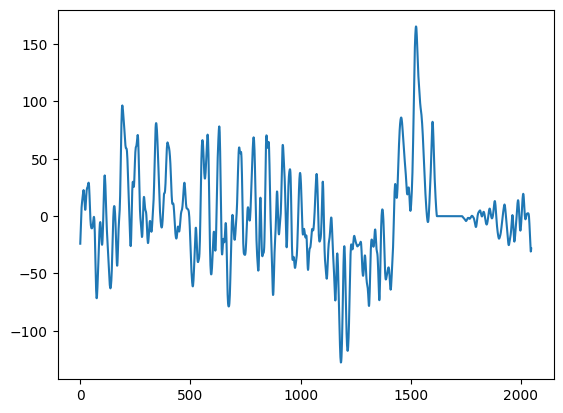

In [72]:
plt.plot(corr)

In [33]:
from Bio import SeqIO

def reverse_complement(dna: str) -> str:
    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
    return ''.join(complement[base] for base in reversed(dna))

def parse_biopython(input_fastq):
    for record in SeqIO.parse(input_fastq, 'fastq'):
        yield record

def get_fastq_records(fastq_filepath):
    records = []
    for i, record in enumerate(parse_biopython(fastq_filepath)):
        records.append(record)
    return records

In [36]:
fq_recs = get_fastq_records(r"C:\Users\Parv\Doc\RA\Projects\DSP\data\pod5vsFastq_170524_75ntV2_OK\fastq_pass\ATQ988_pass_22e98598_8902973c_3.fastq\ATQ988_pass_22e98598_8902973c_3.fastq")

In [39]:
from Levenshtein import distance

In [82]:
primer = 'CACTTTGGCGTGACGG'
primer = reverse_complement(primer)

In [83]:
for i in fq_recs:
    print(distance(i[-20:], primer))

11
10
10
11
10
12
12
8
12
10
10
8
12
12
11
11
10
12
11
10
13
12
9
13
9
11
12
13
9
10
8
11
13
10
13
10
10
10
12
13
11
8
9
11
10
9
11
8
11
13
10
9
11
10
12
10
10
9
11
9
11
11
10
9
11
11
10
12
10
12
9
10
9
9
13
10
13
12
10
12
10
11
12
10
10
10
10
12
11
9
10
9
13
14
12
12
12
10
10
9
11
9
12
10
10
10
10
12
10
12
13
13
10
12
11
10
7
9
13
10
13
10
10
11
7
12
12
12
13
11
10
9
10
11
10
13
12
10
10
10
6
9
13
8
11
10
8
10
8
10
11
13
12
10
11
10
8
9
9
11
11
10
10
10
10
12
10
11
10
12
11
11
9
9
10
11
10
10
8
10
9
9
9
10
12
9
9
12
9
12
10
9
12
10
11
12
9
12
13
10
12
11
10
11
10
11
10
9
12
10
11
13
11
9
11
12
12
11
8
9
9
9
14
10
12
12
10
11
10
11
13
8
10
9
10
11
11
10
9
9
12
9
9
13
12
11
9
10
11
9
9
12
9
8
10
9
9
11
10
10
8
12
10
10
9
8
9
9
10
8
9
10
9
9
10
9
9
9
11
10
10
11
9
9
8
10
10
12
11
10
11
11
12
10
8
12
10
10
10
11
8
7
11
11
10
12
10
12
9
9
9
9
11
13
12
11
12
8
10
12
13
13
9
9
9
9
11
8
10
11
10
9
10
8
9
11
10
9
12
10
9
12
9
12
11
8
10
11
11
10
9
11
8
11
10
12
11
14
9
12
12
10
10
10
8
10
10
1